# 学習の目標
- ニューラルネットワークにおける過学習の対策としてドロップアウト・ドロップコネクト・正則化を理解する
- MNISTデータセットを利用して正則化の手法を適応した結果を比較できる

## 事前準備
-  このチュートリアルではGPUを用いて処理を行うために、上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUに設定して下さい

In [2]:
# GPUの確認(出力結果がcpuになった場合は上記の手順でランタイムをGPUに変更して下さい)
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## モジュールのインポート

In [3]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

## 学習データの準備

## 課題
0〜9までの手書き数字のデータセットであるMNISTを利用します

- MNISTの概要
  - 0〜9までの手書き数字のデータセット
  - 学習データ:6万枚 テストデータ:1万枚
  - サイズ:28×28


MNISTデータセットを読み込み、1000件だけ学習データとして取得します

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

limited_train_data_images = []
limited_train_data_labels = []

for i, (data, label) in enumerate(train_loader):
    limited_train_data_images.append(data)
    limited_train_data_labels.append(label)
    if i == 30:  # 32*31 = 992件
        break

# バッチの次元を削除して、リストを連結します
limited_train_images = torch.cat(limited_train_data_images)
limited_train_labels = torch.cat(limited_train_data_labels)

# 新しいデータセットを作成
limited_train_dataset = torch.utils.data.TensorDataset(limited_train_images, limited_train_labels)

# DataLoaderを作成
limited_train_loader = torch.utils.data.DataLoader(limited_train_dataset, batch_size=32, shuffle=True)

### ドロップアウト
ドロップアウトはネットワーク内のユニットを一定の割合でランダムに無視して学習を行う手法で正則化の一種です。  
このランダムな無視を学習の段階ごとにランダムで行うことで、それぞれ別のネットワークを持つモデルを複数アンサンブル学習する効果があるため汎化性能の向上に繋がることが実験で示されています。

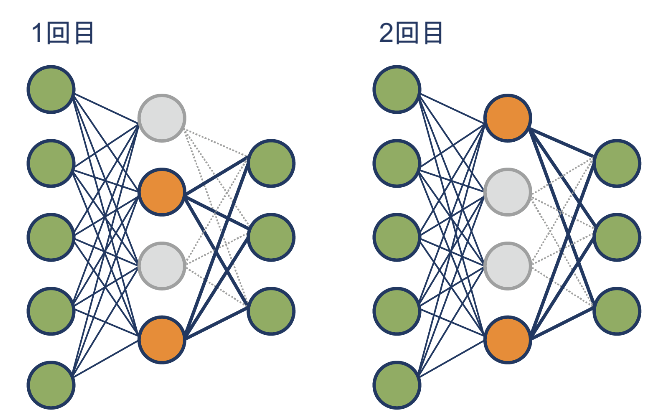




### ドロップコネクト
ドロップコネクトはユニットを無視する代わりに、ユニット間の接続を一定の割合で無視する手法です。  
ドロップコネクトも実質的に同時にいくつものモデル(ノードの乗数個のモデル)を学習させて平均を取ることになり、アンサンブル学習の同じような効果が得られ、テストデータでの予測精度(汎化性能)の向上に寄与することがあります。

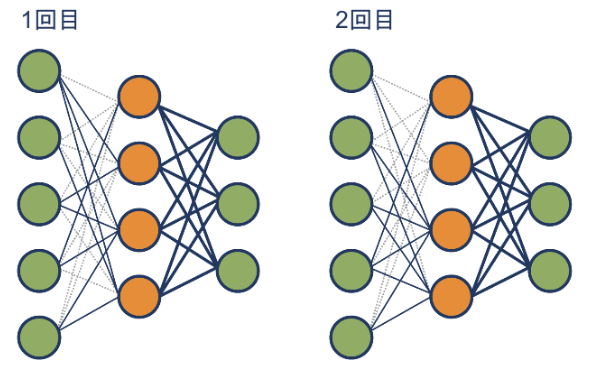

実際にドロップアウトとドロップコネクトがどれくらいの影響があるについてMNISTを用いた実験結果は下記の通りです。  
実験では全てのケースで何も適応しない場合と比較してドロップアウトやドロップコネクトを適応した方が良い精度が出ていることが確認できます。

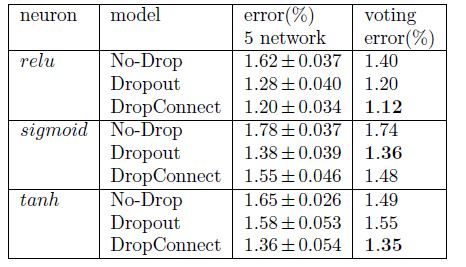  
出典；https://proceedings.mlr.press/v28/wan13.html

In [5]:
# ドロップアウトなしのモデル
class NetWithoutDropout(nn.Module):
    def __init__(self):
        super(NetWithoutDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# ドロップアウトありのモデル
class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 1000)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1000, 500)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(500, 250)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(250, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# モデルの定義
model_without_dropout = NetWithoutDropout().to(device)
model_with_dropout = NetWithDropout().to(device)

In [6]:
# ドロップアウトなしのモデルの構造の表示
summary(model_without_dropout,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]         785,000
            Linear-2                  [-1, 500]         500,500
            Linear-3                  [-1, 250]         125,250
            Linear-4                   [-1, 10]           2,510
Total params: 1,413,260
Trainable params: 1,413,260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 5.39
Estimated Total Size (MB): 5.41
----------------------------------------------------------------


In [7]:
# ドロップアウトありのモデルの構造の表示
summary(model_with_dropout,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]         785,000
           Dropout-2                 [-1, 1000]               0
            Linear-3                  [-1, 500]         500,500
           Dropout-4                  [-1, 500]               0
            Linear-5                  [-1, 250]         125,250
           Dropout-6                  [-1, 250]               0
            Linear-7                   [-1, 10]           2,510
Total params: 1,413,260
Trainable params: 1,413,260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.39
Estimated Total Size (MB): 5.42
----------------------------------------------------------------


## モデルの学習

In [8]:
# 学習関数の定義
def train_and_validate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss_list.append(train_loss / (batch_idx + 1))
        train_acc_list.append(100. * correct / total)

        # Validation Phase
        val_loss, val_acc = evaluate_model(model, test_loader, criterion)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss/(batch_idx+1):.4f}, Train Accuracy: {100.*correct/total:.4f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}%')

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list


# モデルの評価関数の定義
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return val_loss / (batch_idx + 1), 100. * correct / total

## 損失関数とオプティマイザの設定
- 今回は分類問題のため、損失関数にはCrossEntropyLossを使用しています
- 条件を同じにするため、自作モデルと転移学習のモデルのオプティマイザ(最適化手法)にはAdamを使用しています

In [9]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法の適応
optimizer_without_dropout = optim.Adam(model_without_dropout.parameters(), lr=0.001)
optimizer_with_dropout = optim.Adam(model_with_dropout.parameters(), lr=0.001)

In [10]:
# モデルの学習と評価
print('ドロップアウトなしモデル')
train_loss_without_dropout, train_acc_without_dropout, val_loss_without_dropout, val_acc_without_dropout = train_and_validate_model(model_without_dropout, limited_train_loader, test_loader, criterion, optimizer_without_dropout)
print('-'*100)

print('ドロップアウトありモデル')
train_loss_with_dropout, train_acc_with_dropout, val_loss_with_dropout, val_acc_with_dropout = train_and_validate_model(model_with_dropout, limited_train_loader, test_loader, criterion, optimizer_with_dropout)
print('-'*100)

ドロップアウトなしモデル
Epoch: 1, Train Loss: 1.4516, Train Accuracy: 52.4194%, Val Loss: 0.6857, Val Accuracy: 78.0100%
Epoch: 2, Train Loss: 0.4650, Train Accuracy: 85.7863%, Val Loss: 0.6339, Val Accuracy: 80.9600%
Epoch: 3, Train Loss: 0.3083, Train Accuracy: 89.5161%, Val Loss: 0.4353, Val Accuracy: 87.0700%
Epoch: 4, Train Loss: 0.1823, Train Accuracy: 94.3548%, Val Loss: 0.4286, Val Accuracy: 88.3500%
Epoch: 5, Train Loss: 0.1058, Train Accuracy: 97.4798%, Val Loss: 0.4616, Val Accuracy: 87.3400%
Epoch: 6, Train Loss: 0.0788, Train Accuracy: 97.5806%, Val Loss: 0.4008, Val Accuracy: 89.5400%
Epoch: 7, Train Loss: 0.0368, Train Accuracy: 99.0927%, Val Loss: 0.4283, Val Accuracy: 89.3600%
Epoch: 8, Train Loss: 0.0199, Train Accuracy: 99.3952%, Val Loss: 0.4406, Val Accuracy: 89.6200%
Epoch: 9, Train Loss: 0.0201, Train Accuracy: 99.6976%, Val Loss: 0.5253, Val Accuracy: 88.2800%
Epoch: 10, Train Loss: 0.0575, Train Accuracy: 98.1855%, Val Loss: 0.4973, Val Accuracy: 89.0900%
Epoch: 11, Train

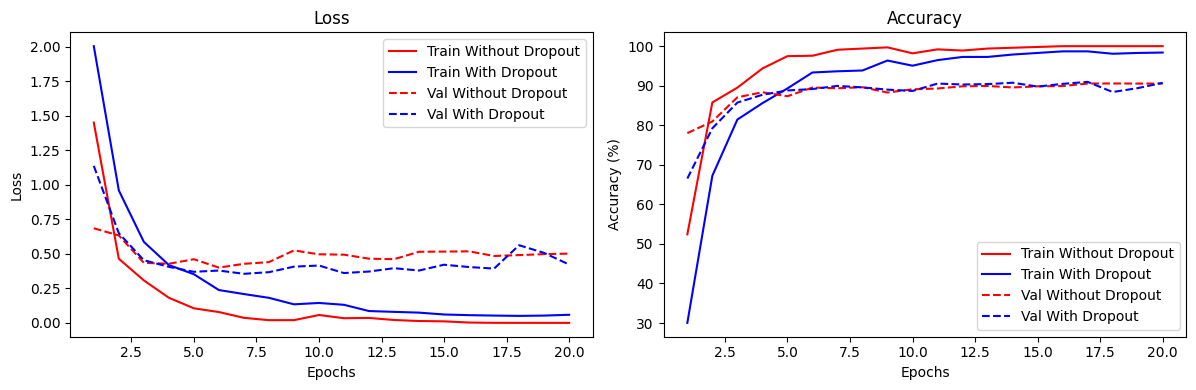

In [11]:
# 損失とAccuracyをグラフで描画
epochs = range(1, 21)
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_without_dropout, 'r', label='Train Without Dropout')
plt.plot(epochs, train_loss_with_dropout, 'b', label='Train With Dropout')
plt.plot(epochs, val_loss_without_dropout, 'r--', label='Val Without Dropout')
plt.plot(epochs, val_loss_with_dropout, 'b--', label='Val With Dropout')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc_without_dropout, 'r', label='Train Without Dropout')
plt.plot(epochs, train_acc_with_dropout, 'b', label='Train With Dropout')
plt.plot(epochs, val_acc_without_dropout, 'r--', label='Val Without Dropout')
plt.plot(epochs, val_acc_with_dropout, 'b--', label='Val With Dropout')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 正則化
正則化は、ニューラルネットワークが訓練データに過度にフィットすること、すなわち過学習を防ぐための技術です。   
過学習は、モデルが訓練データに対して高い精度を持ちながら、未知のデータ（テストデータ）に対しては低い精度を持つ状態を指します。

正則化の代表的なものとして、L1正則化とL2正則化があります。

- **L1正則化(Lasso)**  
  L1正則化は、ペナルティ項としてパラメータの絶対値の合計を加える手法です。この結果、不要なパラメータが0になることが多く、モデルが疎（スパース）になります。これは、モデルの中で真に重要な特徴だけを取り出し、ノイズや不要な情報を取り除く効果があります。

- **L2正則化(Ridge)**  
  L2正則化は、ペナルティ項としてパラメータの二乗の合計を加える手法です。L1とは異なり、L2正則化はパラメータを完全に0にすることは少なく、全体的にパラメータの値を小さく抑える効果があります。これにより、モデルの複雑さが制約され、過学習を防ぐことができます。

In [31]:
def train(model, loader, optimizer, criterion, device, regularization=None, lambda_reg=0.01):
    model.train()
    model.to(device)
    total_loss = 0.0

    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        # L1 正則化
        if regularization == 'L1':
          l1_reg = torch.tensor(0., device=device)
          l1_reg += torch.norm(model.fc1.weight, 1)  # 最初の全結合層の重みのみ使用
          loss += lambda_reg * l1_reg

        # L2 正則化はoptimizerのweight_decayで実現されます
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    model.to(device)
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(loader.dataset)

Training No Regularization...
Training L1 Regularization...
Training L2 Regularization...


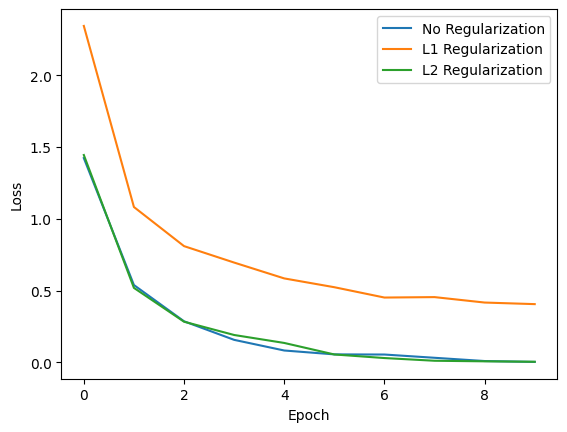

In [32]:
# トレーニングの設定
epochs = 10
lr = 0.001
lambda_reg = 0.0001
criterion = nn.CrossEntropyLoss()

# モデルの設定
models = {
    "No Regularization": NetWithoutDropout(),
    "L1 Regularization": NetWithoutDropout(),
    "L2 Regularization": NetWithoutDropout()
}

# 最適化手法
optimizers = {
    "No Regularization": optim.Adam(models["No Regularization"].parameters(), lr=lr),
    "L1 Regularization": optim.Adam(models["L1 Regularization"].parameters(), lr=lr),
    "L2 Regularization": optim.Adam(models["L2 Regularization"].parameters(), lr=lr, weight_decay=lambda_reg)  # L2正則化はこちらで
}

histories = {
    "No Regularization": [],
    "L1 Regularization": [],
    "L2 Regularization": []
}

# トレーニングの実行
for name, model in models.items():
    print(f"Training {name}...")
    for epoch in range(epochs):
        if name == "L1 Regularization":
            loss = train(model, limited_train_loader, optimizers[name], criterion, device, regularization='L1', lambda_reg=lambda_reg)
        else:
            loss = train(model, limited_train_loader, optimizers[name], criterion, device)
        histories[name].append(loss)

# 結果のプロット
for name, history in histories.items():
    plt.plot(history, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# Accuracyの表示
for name, model in models.items():
    train_accuracy = evaluate(model, limited_train_loader, device)
    print(f"{name} Train Accuracy: {train_accuracy:.2f}%")
    test_accuracy = evaluate(model, test_loader, device)
    print(f"{name} Test Accuracy: {test_accuracy:.2f}%")
    print('-'*100)

No Regularization Train Accuracy: 100.00%
No Regularization Test Accuracy: 89.90%
----------------------------------------------------------------------------------------------------
L1 Regularization Train Accuracy: 98.39%
L1 Regularization Test Accuracy: 87.93%
----------------------------------------------------------------------------------------------------
L2 Regularization Train Accuracy: 100.00%
L2 Regularization Test Accuracy: 89.99%
----------------------------------------------------------------------------------------------------


正則化の有無や種類によってニューラルネットワークの重みがどのように分布するかを可視化してみます。  
正則化の種類によって、ニューラルネットワークの重みの分布が変化します。   
具体的に、L1正則化は重みを0に集中させ、L2正則化は重みの大きさを制限していることが、添付のグラフから確認できると思います。

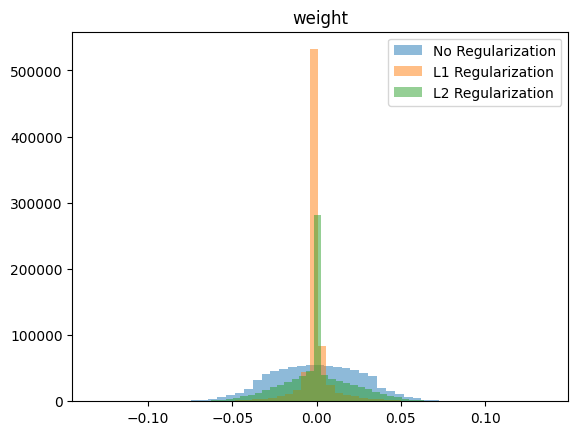

In [35]:
# 重みの可視化
weights_no_reg = []
weights_l1_reg = []
weights_l2_reg = []

for name, param in models["No Regularization"].named_parameters():
    if 'fc1.weight' in name:
        weights_no_reg.extend(param.data.flatten().tolist())
for name, param in models["L1 Regularization"].named_parameters():
    if 'fc1.weight' in name:
        weights_l1_reg.extend(param.data.flatten().tolist())
for name, param in models["L2 Regularization"].named_parameters():
    if 'fc1.weight' in name:
        weights_l2_reg.extend(param.data.flatten().tolist())

plt.figure()
plt.title('weight')
plt.hist(weights_no_reg, bins=50, alpha=0.5, label='No Regularization')
plt.hist(weights_l1_reg, bins=50, alpha=0.5, label='L1 Regularization')
plt.hist(weights_l2_reg, bins=50, alpha=0.5, label='L2 Regularization')
plt.legend()
plt.show()

## 課題
1. ドロップコネクトを実装してみてドロップアウトの結果と比較してみよう

In [14]:
# ここにコードを実装


2. 正則化の強度を変えて重みの分布や精度がどのように変化するかみてみよう

In [36]:
# ここにコードを実装
